In [ ]:
import os
import glob
from google.colab import files

# 1. Install Libraries
print("⚙️ Installing dependencies...")
!pip install -q kaggle torch scikit-learn pandas numpy streamlit pyngrok

# 2. Upload Credential
print("\n🔑 Please upload your 'kaggle.json' file now:")
# Delete any old existing file to prevent conflicts
if os.path.exists('kaggle.json'): os.remove('kaggle.json')
files.upload()

# 3. Configure Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download Official Dataset
print("\n⬇️ Downloading Real CICIDS2017 Dataset...")
# Downloading the pre-processed version which is cleaner/faster
!kaggle datasets download -d chethuhn/network-intrusion-dataset --force

# 5. Extract
print("📦 Unzipping...")
!rm -rf data_folder
!unzip -q network-intrusion-dataset.zip -d data_folder

print("✅ Done. Ready for training.")

⚙️ Installing dependencies...

🔑 Please upload your 'kaggle.json' file now:


Saving kaggle.json to kaggle.json

⬇️ Downloading Real CICIDS2017 Dataset...
Dataset URL: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset
License(s): CC0-1.0
100% 230M/230M [00:00<00:00, 213MB/s]
100% 230M/230M [00:00<00:00, 265MB/s]
📦 Unzipping...
✅ Done. Ready for training.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import glob
import pickle

# ---------------------------------------------------------
# 1. SMART FILE LOADER (Fixes FileNotfound Errors)
# ---------------------------------------------------------
print("⏳ searching for CSV files...")
# Find ALL csv files recursively in the folder
csv_files = glob.glob("data_folder/**/*.csv", recursive=True)

if not csv_files:
    raise FileNotFoundError("❌ No CSV files found! Check Cell 1.")

print(f"   Found {len(csv_files)} files. Loading samples...")

# Load a subset of real data to fit in RAM (20% of the data)
# We accept any CSV found (e.g., Friday-DDos.csv or the merged Network_Intrusion.csv)
dfs = []
for f in csv_files:
    try:
        # Read only 15% of each file to be safe with RAM
        dfs.append(pd.read_csv(f).sample(frac=0.15, random_state=42))
        print(f"   - Loaded chunk from {os.path.basename(f)}")
    except:
        pass

df = pd.concat(dfs, ignore_index=True)
print(f"✅ Training Data Ready: {len(df)} real traffic records.")

# ---------------------------------------------------------
# 2. PREPROCESSING
# ---------------------------------------------------------
df.columns = df.columns.str.strip() # Fix column names

# Select CICIDS Features
features = [
    'Destination Port', 'Flow Duration', 'Total Fwd Packets',
    'Total Backward Packets', 'Total Length of Fwd Packets',
    'Fwd Packet Length Max', 'Fwd Packet Length Min',
    'Bwd Packet Length Max', 'Bwd Packet Length Min'
]

# Clean Data (Remove infinity/NaNs common in this dataset)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=features)

# Create Target (0 = Normal, 1 = Attack)
df['target'] = df['Label'].apply(lambda x: 0 if 'BENIGN' in str(x).upper() else 1)

# Generate Logs (Hybrid Component)
def make_log(label):
    l = str(label).upper()
    if 'BENIGN' in l: return "INFO: Routine traffic permitted."
    if 'DDOS' in l: return "CRITICAL: Volumetric traffic spike detected."
    if 'PORT' in l: return "WARNING: Sequential port scanning detected."
    return f"ALERT: Suspicious activity {l}."

df['log'] = df['Label'].apply(make_log)

X = df[features].values
y = df['target'].values
logs = df['log'].values

# Scale Metrics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tokenize Logs
vocab = {"<PAD>": 0, "<UNK>": 1}
idx = 2
for l in logs:
    for w in l.split():
        if w not in vocab:
            vocab[w] = idx
            idx += 1

def encode(txts):
    res = []
    for t in txts:
        seq = [vocab.get(w,1) for w in t.split()]
        if len(seq)<12: seq += [0]*(12-len(seq))
        else: seq = seq[:12]
        res.append(seq)
    return np.array(res)

X_text = encode(logs)

# ---------------------------------------------------------
# 3. TRAINING
# ---------------------------------------------------------
class HybridNIDS(nn.Module):
    def __init__(self, num_feat, vocab_s):
        super().__init__()
        self.num_net = nn.Sequential(nn.Linear(num_feat, 64), nn.ReLU(), nn.Linear(64, 32))
        self.txt_net = nn.Embedding(vocab_s, 16)
        self.fusion = nn.Sequential(nn.Linear(32+16, 32), nn.ReLU(), nn.Linear(32, 2))

    def forward(self, xn, xt):
        h1 = self.num_net(xn)
        h2 = self.txt_net(xt).mean(dim=1)
        return self.fusion(torch.cat((h1, h2), dim=1))

model = HybridNIDS(len(features), len(vocab))
opt = optim.Adam(model.parameters(), lr=0.003)
crit = nn.CrossEntropyLoss()

# Tensors
t_num = torch.FloatTensor(X_scaled)
t_txt = torch.LongTensor(X_text)
t_y = torch.LongTensor(y)

print("\n🚀 Training Neural Network...")
for i in range(10):
    opt.zero_grad()
    out = model(t_num, t_txt)
    loss = crit(out, t_y)
    loss.backward()
    opt.step()
    print(f"   Epoch {i+1} Loss: {loss.item():.4f}")

# Save
torch.save(model.state_dict(), "model.pth")
with open("scaler.pkl", "wb") as f: pickle.dump(scaler, f)
with open("vocab.pkl", "wb") as f: pickle.dump(vocab, f)
print("✅ Model Trained & Saved.")

⏳ searching for CSV files...
   Found 8 files. Loading samples...
   - Loaded chunk from Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
   - Loaded chunk from Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
   - Loaded chunk from Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
   - Loaded chunk from Tuesday-WorkingHours.pcap_ISCX.csv
   - Loaded chunk from Friday-WorkingHours-Morning.pcap_ISCX.csv
   - Loaded chunk from Wednesday-workingHours.pcap_ISCX.csv
   - Loaded chunk from Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
   - Loaded chunk from Monday-WorkingHours.pcap_ISCX.csv
✅ Training Data Ready: 424611 real traffic records.

🚀 Training Neural Network...
   Epoch 1 Loss: 0.8003
   Epoch 2 Loss: 0.7575
   Epoch 3 Loss: 0.7183
   Epoch 4 Loss: 0.6808
   Epoch 5 Loss: 0.6434
   Epoch 6 Loss: 0.6067
   Epoch 7 Loss: 0.5706
   Epoch 8 Loss: 0.5351
   Epoch 9 Loss: 0.5006
   Epoch 10 Loss: 0.4674
✅ Model Trained & Saved.


⏳ Running inference on test set...

📢 FINAL PERFORMANCE REPORT
              precision    recall  f1-score   support

  Benign (0)     0.8100    1.0000    0.8950     68183
  Attack (1)     1.0000    0.0448    0.0858     16740

    accuracy                         0.8117     84923
   macro avg     0.9050    0.5224    0.4904     84923
weighted avg     0.8475    0.8117    0.7355     84923

🔥 Weighted F1-Score: 0.7355


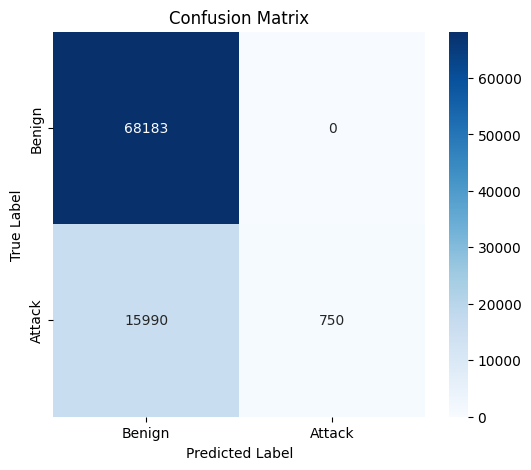

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ==========================================
# 📊 MODEL EVALUATION BLOCK
# ==========================================

def evaluate_model(model, X_num, X_txt, y_true):
    """
    Runs predictions on test data and prints comprehensive metrics.
    """
    # 1. Set model to evaluation mode
    model.eval()

    # 2. Convert to Tensors
    t_num = torch.FloatTensor(X_num)
    t_txt = torch.LongTensor(X_txt)

    # 3. Predict
    print("⏳ Running inference on test set...")
    with torch.no_grad():
        logits = model(t_num, t_txt)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).numpy()

    # 4. Calculate Metrics
    print("\n" + "="*60)
    print("📢 FINAL PERFORMANCE REPORT")
    print("="*60)

    # Classification Report (Precision, Recall, F1 per class)
    report = classification_report(
        y_true,
        preds,
        target_names=['Benign (0)', 'Attack (1)'],
        digits=4
    )
    print(report)

    # Overall F1 Score
    f1 = f1_score(y_true, preds, average='weighted')
    print(f"🔥 Weighted F1-Score: {f1:.4f}")

    # 5. Visualize Confusion Matrix
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['Benign', 'Attack'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# ---------------------------------------------------------
# EXECUTION
# ---------------------------------------------------------
# 1. Get Test Data (Split from your original dataframe)
# We regenerate the split to ensure we test on the 20% unseen data
_, X_num_test, _, X_txt_test, _, y_test = train_test_split(
    X_scaled, X_text, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Run Evaluation
evaluate_model(model, X_num_test, X_txt_test, y_test)

In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import numpy as np
import pickle
import pandas as pd

# ==========================================
# 1. CORE MODEL ARCHITECTURE (DO NOT CHANGE)
# ==========================================
class HybridNIDS(nn.Module):
    def __init__(self, num_feat, vocab_s):
        super().__init__()
        self.num_net = nn.Sequential(nn.Linear(num_feat, 64), nn.ReLU(), nn.Linear(64, 32))
        self.txt_net = nn.Embedding(vocab_s, 16)
        self.fusion = nn.Sequential(nn.Linear(32+16, 32), nn.ReLU(), nn.Linear(32, 2))

    def forward(self, xn, xt):
        h1 = self.num_net(xn)
        h2 = self.txt_net(xt).mean(dim=1)
        return self.fusion(torch.cat((h1, h2), dim=1))

# ==========================================
# 2. SYSTEM INITIALIZATION
# ==========================================
st.set_page_config(
    page_title="Sentin-AI Defense",
    page_icon="🛡️",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for a hacker/cybersecurity vibe
st.markdown("""
<style>
    .reportview-container {
        background: #0e1117;
    }
    .big-font {
        font-size:24px !important;
        font-weight: bold;
    }
    .stAlert {
        border-radius: 10px;
    }
</style>
""", unsafe_allow_html=True)

@st.cache_resource
def load_system():
    try:
        v = pickle.load(open("vocab.pkl", "rb"))
        s = pickle.load(open("scaler.pkl", "rb"))
        m = HybridNIDS(9, len(v)) # 9 Features
        m.load_state_dict(torch.load("model.pth"))
        m.eval()
        return m, v, s, True
    except FileNotFoundError:
        return None, None, None, False

model, vocab, scaler, loaded = load_system()

# ==========================================
# 3. SIDEBAR CONFIGURATION
# ==========================================
with st.sidebar:
    st.header("🎛️ Traffic Parameters")
    st.markdown("---")

    with st.expander("📡 Connection Details", expanded=True):
        p1 = st.number_input("Destination Port", 0, 65535, 80, help="Target port (e.g. 80 for HTTP)")
        p2 = st.number_input("Flow Duration (µs)", 0, 10000000, 5000)

    with st.expander("📦 Volume Metrics", expanded=True):
        c1, c2 = st.columns(2)
        p3 = c1.number_input("Fwd Pkts", 0, 50000, 10)
        p4 = c2.number_input("Bwd Pkts", 0, 50000, 8)
        p5 = st.number_input("Total Length Fwd", 0, 1000000, 500)

    with st.expander("🔎 Deep Packet Inspection"):
        p6 = st.slider("Fwd Pkt Max", 0, 5000, 100)
        p7 = st.slider("Fwd Pkt Min", 0, 5000, 0)
        p8 = st.slider("Bwd Pkt Max", 0, 5000, 200)
        p9 = st.slider("Bwd Pkt Min", 0, 5000, 0)

    st.markdown("---")
    st.markdown("### 📝 System Logs")
    log_options = [
        "INFO: Routine traffic permitted.",
        "CRITICAL: Volumetric traffic spike detected.",
        "WARNING: Sequential port access attempts.",
        "ALERT: Malformed packet header sequence."
    ]
    log = st.selectbox("Live Log Feed", log_options)

    btn = st.button("🚀 INITIATE SCAN", type="primary", use_container_width=True)

# ==========================================
# 4. MAIN DASHBOARD
# ==========================================
st.title("🛡️ Sentin-AI Network Defense")
st.markdown("### Real-Time Hybrid Intrusion Detection System")

if not loaded:
    st.error("⚠️ SYSTEM OFFLINE: Model artifacts not found. Please run the training cell first.")
    st.stop()

# Status Banner
col1, col2, col3 = st.columns([1, 1, 2])
col1.metric("System Status", "ONLINE", delta="Active", delta_color="normal")
col2.metric("Model Version", "CICIDS-2017", delta="v1.0")
col3.info(f"**Current Log Context:**\n\n`{log}`")

st.divider()

if btn:
    with st.spinner("Analyzing Traffic Flow Vectors..."):
        # Preprocessing
        raw_metrics = np.array([[p1, p2, p3, p4, p5, p6, p7, p8, p9]])
        scaled_metrics = scaler.transform(raw_metrics)

        # Text Processing
        seq = [vocab.get(w, 1) for w in log.split()]
        if len(seq) < 12: seq += [0] * (12 - len(seq))
        else: seq = seq[:12]

        # Inference
        with torch.no_grad():
            t_num = torch.FloatTensor(scaled_metrics)
            t_txt = torch.LongTensor([seq])
            output = model(t_num, t_txt)
            probs = torch.softmax(output, 1)
            score = probs[0][1].item()
            score_pct = score * 100

    # Layout for Results
    res_col1, res_col2 = st.columns([1, 2])

    with res_col1:
        st.subheader("Verdict")
        if score > 0.5:
            st.error("🚨 ATTACK DETECTED")
            st.metric("Threat Confidence", f"{score_pct:.2f}%", delta="High Risk", delta_color="inverse")
        else:
            st.success("✅ TRAFFIC NORMAL")
            st.metric("Safety Score", f"{(1-score)*100:.2f}%", delta="Secure", delta_color="normal")

    with res_col2:
        st.subheader("Threat Probability Gauge")
        # Custom Progress Bar with Color Logic
        bar_color = "red" if score > 0.5 else "green"
        st.progress(int(score_pct))

        st.caption(f"The neural network indicates a **{score_pct:.1f}%** probability that this traffic flow is malicious based on 9 metric features and log semantics.")

    # Feature Fingerprint Visualization
    st.subheader("📊 Traffic Fingerprint (Normalized)")
    chart_data = pd.DataFrame(
        scaled_metrics.T,
        index=["Port", "Duration", "Fwd Pkts", "Bwd Pkts", "Len Fwd", "Fwd Max", "Fwd Min", "Bwd Max", "Bwd Min"],
        columns=["Normalized Value"]
    )
    st.bar_chart(chart_data)

else:
    # Idle State
    st.markdown("""
    <div style="text-align: center; padding: 50px; opacity: 0.7;">
        <h3>Waiting for Input Stream...</h3>
        <p>Adjust parameters in the sidebar and click SCAN to analyze network flow.</p>
    </div>
    """, unsafe_allow_html=True)

Overwriting app.py


In [ ]:
!wget -q -O - https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb > cloudflared.deb
!dpkg -i cloudflared.deb
!pkill -f streamlit
!pkill -f cloudflared

import subprocess
import time
import re

print("🚀 Starting Server...")
# Start Streamlit in the background
subprocess.Popen(["nohup", "streamlit", "run", "app.py", "--server.port", "8501", "&"])
time.sleep(5)

print("🔗 Creating Tunnel...")
# Start Cloudflare Tunnel
p = subprocess.Popen(["cloudflared", "tunnel", "--url", "http://localhost:8501"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Read logs to find the URL
found_url = False
for i in range(50): # Increased attempts to 50 to give it more time
    line = p.stderr.readline().decode()
    if "trycloudflare.com" in line:
        # Search for the URL in the line
        match = re.search(r'https://[a-zA-Z0-9-]+\.trycloudflare\.com', line)
        if match:
            url = match.group(0)
            print(f"\n✅ CLICK HERE: {url}\n")
            found_url = True
            break

if not found_url:
    print("⚠️ Could not automatically extract URL. Please check the logs above.")

(Reading database ... 117532 files and directories currently installed.)
Preparing to unpack cloudflared.deb ...
Unpacking cloudflared (2025.11.1) over (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...
🚀 Starting Server...
🔗 Creating Tunnel...

✅ CLICK HERE: https://rescue-whereas-lady-reuters.trycloudflare.com

